In [1]:
%load_ext autoreload
%autoreload 2

# Load Packages

In [2]:
import torch
import os
import torch.nn as nn
import torchaudio
from textless.data.speech_encoder import SpeechEncoder
from matplotlib import pyplot as plt
# from torch_kmeans import KMeans

# Load SpeechEncoder

## SpeechEncoder from textless

从textless下载并加载SpeechEncoder模型。

In [5]:
class MySpeechEncoder(nn.Module):
    def __init__(self, dense_model_name="hubert-base-ls960", quantizer_name="kmeans", vocab_size=500):
        super().__init__()
        self.model = self.load_SpeechEncoder(dense_model_name, quantizer_name=quantizer_name, vocab_size=vocab_size)

    def load_SpeechEncoder(self, dense_model_name, quantizer_name="kmeans", vocab_size=500):
        # We can build a speech encoder module using names of pre-trained
        # dense and quantizer models.  The call below will download
        # appropriate checkpoints as needed behind the scenes. We can
        # also construct an encoder by directly passing model instances
        self.encoder = SpeechEncoder.by_name(
            dense_model_name=dense_model_name,
            quantizer_model_name=quantizer_name,
            vocab_size=vocab_size,
            deduplicate=True,
            need_f0=False,
        )
        return self.encoder

    def encode_speech(self, x):
        # res is a dict with keys ('dense', 'units', 'durations').
        # It can also contain 'f0' if SpeechEncoder was initialized
        # with need_f0=True flag.
        """

        Return:
            a dict with {
                "units" : a unit id list, with no repetition
                "dense" : a tensor with shape (T, 768)
                "durations" : the duration for each unit in the `units`
                "original_units": a unit id list with length `T`
            }
        """
        res = self.model(x)

        units = res["units"]  # tensor([71, 12, 57, ...], ...)
        res["original_units"] = torch.repeat_interleave(units, res["durations"])
        return res

In [6]:
speech_encoder = MySpeechEncoder(vocab_size=100)

2024-11-26 20:49:06 | INFO | fairseq.tasks.hubert_pretraining | current directory is /home/ay/Coding2/0-Deepfake/2-Audio/models/OurModels/textless
2024-11-26 20:49:06 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': '/checkpoint/wnhsu/data/librispeech/960h/iter/250K_50hz_km100_mp0_65_v2', 'fine_tuning': False, 'labels': ['layer6.km500'], 'label_dir': None, 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2024-11-26 20:49:06 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 

## Custom SpeechEncoder 

In [3]:
import sys
sys.path.append("/home/ay/Coding2/0-Deepfake/2-Audio/experiments/speech_tokenization")

In [4]:
from kmeans_model import CustomSpeechEncoder

In [5]:
custom_speech_encoder = CustomSpeechEncoder(vocab_size=150)

/home/ay/anaconda3/envs/torch/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/ay/anaconda3/envs/torch/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at microsoft/wavlm-base were not used when initializing WavLMModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMModel from the checkpoint of a model trained on anothe

# 加载数据集　

In [6]:
import sys

sys.path.insert(0, "/home/ay/zky/Coding2/0-Deepfake/2-Audio")

In [7]:
import pandas as pd
import torch
import torch.nn.functional as F
from ay2.torch.data import WaveDataset
from torch.utils.data import DataLoader, Dataset, Sampler, default_collate, random_split

In [8]:
from ay2.datasets.audio import MLAAD_AudioDs
from ay2.torchaudio.transforms.self_operation import CentralAudioClip
from tqdm import tqdm

In [9]:
def load_MLAAD_subset(root_path: str = "/home/ay/data/0-原始数据集/MLADD", language: str = "en", n_audios=1000):
    ds = MLAAD_AudioDs(root_path=root_path)
    if isinstance(language, str):
        data = ds.data.query(f"language == {language}")
    else:
        data = ds.data.query(f"language in {language}")

    sampled_data = [data.query(f"label == {i}").sample(n_audios // 2, random_state=42) for i in [0, 1]]
    sampled_data = pd.concat(sampled_data, ignore_index=True)

    _ds = WaveDataset(
        sampled_data,
        sample_rate=16000,
        normalize=True,
        transform=[CentralAudioClip(64000)],
        dtype="tensor",
    )

    _dl = DataLoader(_ds, num_workers=5, batch_size=4, shuffle=False)
    return _dl

In [10]:
dl_en = load_MLAAD_subset(language=["de"], n_audios=1000)

# 生成结果　

## help function　

In [11]:
import time

from torch import Tensor

:::{note}
在音素识别时，一个音素可能会跨多个时间帧，因此需要合并连续且相同的音素，构造为一个音素，从而预测整句话的音素，并与ground truth进行比较。
:::

那使用音素特征识别时，那么也许合并连续且相同的音素特征帧。设音素特征为`(B, T, 768)`，那么合并后的特征为`(B, T', 768)`。

In [12]:
def segment_means(x: torch.Tensor, segment_sizes: torch.Tensor) -> torch.Tensor:
    """
    Args:
      tensor: torch.Tensor: a 2D tensor with shape of `(L, C)`
      segment_sizes: torch.Tensor: a 1D tensor that its sum is equal to the length `L` of tensor

    Returns:
        torch.Tenosr: the tensor with reduce length `(L', C)`, where $L'=len(segment_sizes)$
    """
    assert x.size(0) == segment_sizes.sum(), "Sum of segment sizes must equal the tensor's first dimension size."

    # Create an indices tensor that maps each row in the tensor to its corresponding segment
    indices = torch.repeat_interleave(torch.arange(len(segment_sizes), device=x.device), segment_sizes)

    # Create a tensor to hold the sum of each segment
    segment_sums = torch.zeros(len(segment_sizes), x.size(1), device=x.device)

    # Scatter and sum the inputs into the segment_sums tensor
    segment_sums.scatter_add_(0, indices.unsqueeze(1).expand(-1, x.size(1)), x)

    # Calculate the mean of each segment
    segment_means = segment_sums / segment_sizes.unsqueeze(1)

    return segment_means

In [17]:
## 验证
x = torch.randn(5, 1)
segments = torch.tensor([1, 2, 2])
res = segment_means(x, segments)
print(x, "\n", res)

tensor([[ 0.4144],
        [ 0.5599],
        [ 0.0624],
        [-0.7970],
        [ 0.6380]]) 
 tensor([[ 0.4144],
        [ 0.3112],
        [-0.0795]])


In [13]:
def reduce_feat_by_phonemes(
    hidden_states: Tensor, audio_lengths: Tensor, phoneme_ids: Tensor, debug: bool = False
) -> Tensor:
    """
    For each audio, combine continuous phonemes to reduce the temporal dimension of audio features.
    For example, the audio with 10 frames, which phoneme ids will change from
    ```python
    [0, 0, 0, 1, 1, 1, 2, 2, 0, 0] -> [0, 1, 2, 0]
    ```
    and the hidden_states will also changed by this way.


    Args:
      hidden_states:Tensor: a 3D tensor with shape of (B, T, C), where T is audio frames
      audio_lengths:Tensor: a 1D tensor with shape of (B,) that represent the legnth of each audio
      phoneme_ids:Tensor: a 2D tensor with shape of (B, T) that represents the phoneme ids in each audio frame
      debug:bool: determine whether to debug tensor info.

    Returns:
        the reduced hidden_states with shape (B*L', C), reduced audio lengths, reduced phoneme ids.
    """

    reduced_hidden_states = []
    reduced_audio_lengths = []
    reduced_phoneme_ids = []
    phoneme_counts = []

    if debug:
        s = time.time()
        print("reduce feat input:", hidden_states.shape, audio_lengths.shape, phoneme_ids.shape)

    for i in range(len(audio_lengths)):
        _phoneme_ids = phoneme_ids[i, : audio_lengths[i]]
        unique_ids, _phoneme_counts = _phoneme_ids.unique_consecutive(return_counts=True)
        phoneme_counts += _phoneme_counts.tolist()

        reduced_audio_lengths.append(len(unique_ids))
        reduced_phoneme_ids.append(unique_ids)

    reduced_audio_lengths = torch.tensor(reduced_audio_lengths)
    reduced_phoneme_ids = torch.nn.utils.rnn.pad_sequence(reduced_phoneme_ids, batch_first=True)
    h = torch.concat([hidden_states[i, :_len, :] for i, _len in enumerate(audio_lengths)], dim=0)
    reduced_hidden_states = segment_means(h, torch.tensor(phoneme_counts, device=hidden_states.device))

    if debug:
        e = time.time()
        print(
            "reduce feat output:", reduced_hidden_states.shape, reduced_audio_lengths.shape, reduced_phoneme_ids.shape
        )
        print("reduce feat time:", e - s)
    return reduced_hidden_states, reduced_audio_lengths, reduced_phoneme_ids

In [14]:
def get_id_based_frame_res(_dense_res, _full_unit_res):
    reduced_hidden_states, reduced_audio_lengths, reduced_phoneme_ids = reduce_feat_by_phonemes(
        hidden_states=torch.tensor(_dense_res),
        audio_lengths=torch.tensor([149] * len(_dense_res)),
        phoneme_ids=torch.tensor(_full_unit_res),
        debug=1,
    )

    split_res = torch.split(reduced_hidden_states, tuple(reduced_audio_lengths.numpy()))

    id_based_frame_res = torch.stack([x.mean(0) for x in split_res]).numpy()
    return id_based_frame_res

## Textless

### Load data and Collect res　

In [19]:
speech_encoder = speech_encoder.to("cuda:0")
dense_res = []
frame_res = []
unit_res = []
full_unit_res = []

for batch in tqdm(dl_en):
    for x in batch["audio"]:  ### torch.Size([1, 48000])
        with torch.no_grad():
            res = speech_encoder.encode_speech(x=x.cuda(0))
            dense_res.append(res["dense"])
            frame_res.append(res["dense"].mean(0))
            unit_res.append(res["units"])
            full_unit_res.append(res["original_units"])

dense_res = torch.stack(dense_res).cpu().numpy()
frame_res = torch.stack(frame_res).cpu().numpy()
full_unit_res = torch.stack(full_unit_res).cpu().numpy()
unit_res = torch.nn.utils.rnn.pad_sequence(unit_res, batch_first=True).cpu().numpy()

vocoder_labels = list(dl_en.dataset.data["vocoder_label"])
labels = list(dl_en.dataset.data["label"])

100%|██████████| 750/750 [00:23<00:00, 32.36it/s]


In [20]:
reduced_hidden_states, reduced_audio_lengths, reduced_phoneme_ids = reduce_feat_by_phonemes(
    hidden_states=torch.tensor(dense_res),
    audio_lengths=torch.tensor([149] * len(dense_res)),
    phoneme_ids=torch.tensor(full_unit_res),
    debug=1,
)

split_res = torch.split(reduced_hidden_states, tuple(reduced_audio_lengths.numpy()))

id_based_frame_res = torch.stack([x.mean(0) for x in split_res]).numpy()

reduce feat input: torch.Size([3000, 199, 768]) torch.Size([3000]) torch.Size([3000, 199])
reduce feat output: torch.Size([259433, 768]) torch.Size([3000]) torch.Size([3000, 122])
reduce feat time: 0.6452486515045166


### 可视化　

In [15]:
from ay2.visualization._scatter import plot_cluster_res
from ay2.visualization.tsne import plot_tSNE_res, tSNE_cluster
from ay2.visualization._utils import calculate_clustering_scores

In [22]:
calculate_clustering_scores(id_based_frame_res, n_clusters=2, labels=labels)
calculate_clustering_scores(frame_res, n_clusters=2, labels=labels)
calculate_clustering_scores(unit_res, n_clusters=2, labels=labels)
calculate_clustering_scores(full_unit_res, n_clusters=2, labels=labels)

Silhouette Score: 0.05349663272500038 Davies-Bouldin Index: 4.391655048151248 Calinski-Harabasz Index: 143.91259236289136
Silhouette Score: 0.17390312254428864 Davies-Bouldin Index: 2.285116856877186 Calinski-Harabasz Index: 375.336199657712
Silhouette Score: 0.05791655087846614 Davies-Bouldin Index: 3.6973769118223863 Calinski-Harabasz Index: 207.54445073320068
Silhouette Score: 0.010456286043145066 Davies-Bouldin Index: 8.886378368591558 Calinski-Harabasz Index: 36.291996938607326


(0.010456286043145066, 8.886378368591558, 36.291996938607326)

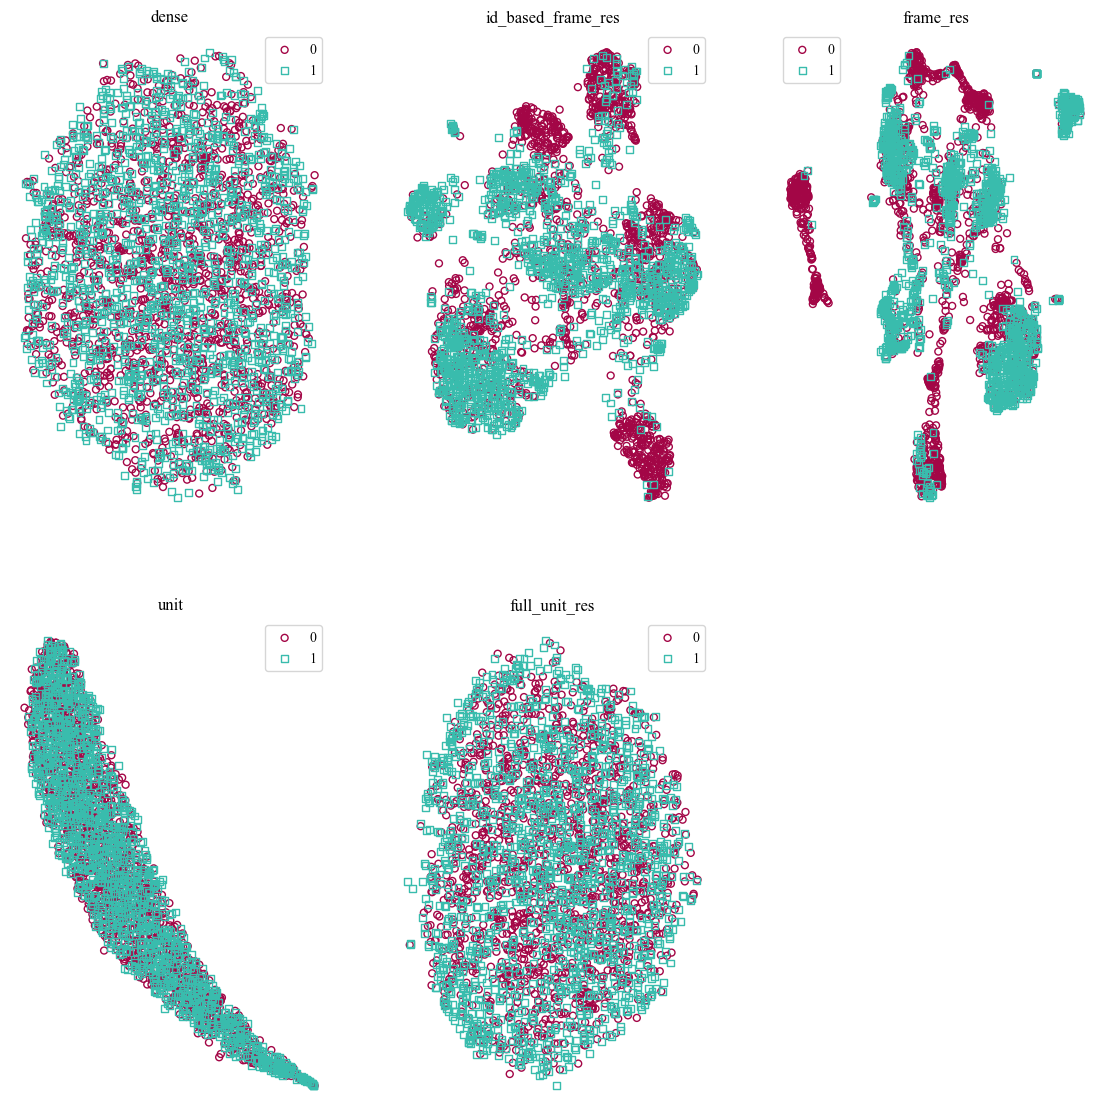

In [23]:
key_feat = {
    'dense': dense_res.mean(-1),
    'id_based_frame_res' : id_based_frame_res,
    'frame_res' : frame_res,
    'unit' : unit_res,
    'full_unit_res': full_unit_res
}

total = len(key_feat)
plt.figure(figsize=(14, 14))
for i, (key, value) in enumerate(key_feat.items()):
    
    ax = plt.subplot(total // 3 + 1, 3, i+1)
    plot_cluster_res(
        value,
        labels=labels,
        cluster_method="umap",
        legend_labels=[0, 1],
        print_cluster_score=False,
        ax=ax
    )
    ax.set_title(key)
plt.show()

## Custom Encoder

In [16]:
def extract_all_features(encoder, dl_en):
    encoder = encoder.to("cuda:0")
    dense_res = []
    frame_res = []
    unit_res = []
    full_unit_res = []
    hidden_states = []

    with torch.no_grad():
        for batch in tqdm(dl_en):
            audio = batch["audio"]

            res = encoder.encode_speech(x=audio.cuda(0))
            
            dense_res.append(res["dense"].cpu())
            frame_res.append(res["dense"].mean(1).cpu())
            unit_res += res["units"]
            full_unit_res.append(torch.tensor(res["original_units"]).cpu())
            res["hidden_states"] = [x.cpu() for x in res["hidden_states"]]
            hidden_states.append(res["hidden_states"])

    dense_res = torch.concat(dense_res).cpu().numpy()
    frame_res = torch.concat(frame_res).cpu().numpy()
    full_unit_res = torch.concat(full_unit_res).cpu().numpy()
    
    unit_res = [torch.tensor(x) for x in unit_res]
    unit_res = torch.nn.utils.rnn.pad_sequence(unit_res, batch_first=True).cpu().numpy()

    vocoder_labels = list(dl_en.dataset.data["vocoder_label"])
    labels = list(dl_en.dataset.data["label"])

    return dense_res, hidden_states, frame_res, full_unit_res, unit_res, vocoder_labels, labels

In [1]:
# for vocab_size in [50, 100, 150, 200, 250]:
for vocab_size in [150]:
    custom_speech_encoder = CustomSpeechEncoder(vocab_size=vocab_size)
    (
        dense_res,
        hidden_states,
        frame_res,
        full_unit_res,
        unit_res,
        vocoder_labels,
        labels,
    ) = extract_all_features(custom_speech_encoder, dl_en)
    # id_based_frame_res = get_id_based_frame_res(dense_res, full_unit_res)

    for i in range(13 + 1):
        if i == 13:
            _hidden_states = torch.concat(
                        [h[0] + h[1] + h[2] for h in hidden_states], dim=0
                    )
        else:
            _hidden_states = torch.concat([h[i] for h in hidden_states], dim=0)
        frame_res2 = _hidden_states.mean(1)
        dense_res2 = _hidden_states.mean(-1)
        id_based_frame_res2 = get_id_based_frame_res(_hidden_states, full_unit_res)
        key_feat = {
            # f'dense-{i}': dense_res2,
            f"frame_res-{i}": frame_res2,
            f"id_based_frame_res-{i}": id_based_frame_res2,
            'unit' : unit_res,
            'full_unit_res': full_unit_res
        }

        total = len(key_feat)
        plt.figure(figsize=(14, 14))
        # for cluster_method in ["tsne", "umap"]:
        for cluster_method in ["tsne"]:
            for i, (key, value) in enumerate(key_feat.items()):
                ax = plt.subplot(2, 2, i + 1)
                save_path = f"pngs/{vocab_size}/{cluster_method}-{key}.png"
                if not os.path.exists(save_path):
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                plot_cluster_res(
                    value,
                    labels=labels,
                    cluster_method="tsne",
                    legend_labels=[0, 1],
                    print_cluster_score=True,
                    ax=ax,
                    save_path=save_path,
                )
                ax.set_title(key)
            plt.show()

NameError: name 'CustomSpeechEncoder' is not defined

### 可视化

In [29]:
from matplotlib import pyplot as plt

In [30]:
key_feat = {
    'dense': dense_res.mean(-1),
    'id_based_frame_res' : id_based_frame_res,
    'frame_res' : frame_res,
    'unit' : unit_res,
    'full_unit_res': full_unit_res
}

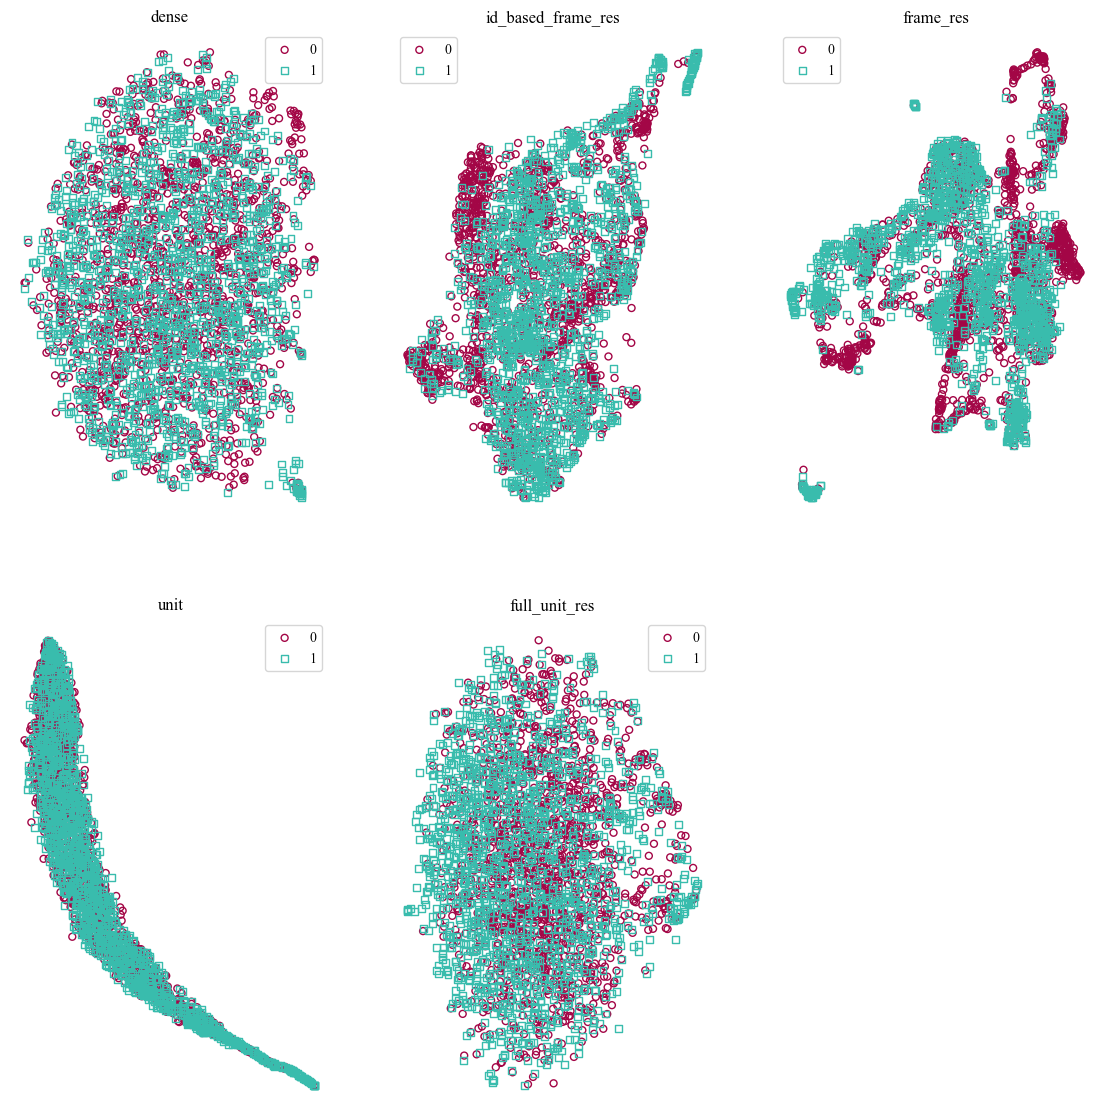

In [31]:
total = len(key_feat)
plt.figure(figsize=(14, 14))
for i, (key, value) in enumerate(key_feat.items()):
    
    ax = plt.subplot(total // 3 + 1, 3, i+1)
    plot_cluster_res(
        value,
        labels=labels,
        cluster_method="umap",
        legend_labels=[0, 1],
        print_cluster_score=False,
        ax=ax
    )
    ax.set_title(key)
plt.show()

In [ ]:
for i in range(13):
    _hidden_states = torch.concat([h[i] for h in hidden_states], dim=0)
    frame_res2 = _hidden_states.mean(1)
    dense_res2 = _hidden_states.mean(-1)
    id_based_frame_res2 = get_id_based_frame_res(_hidden_states, full_unit_res)
    key_feat = {
        # f'dense-{i}': dense_res2,
        f'frame_res-{i}' : frame_res2,
        f'id_based_frame_res-{i}' : id_based_frame_res2,
    }

    total = len(key_feat)
    plt.figure(figsize=(14, 14))
    for i, (key, value) in enumerate(key_feat.items()):
        
        ax = plt.subplot(2, 2, i+1)
        plot_cluster_res(
            value,
            labels=labels,
            cluster_method="umap",
            legend_labels=[0, 1],
            print_cluster_score=True,
            ax=ax,
            save_path=f"pngs-100/{key}.png"
        )
        ax.set_title(key)
    plt.show()

/tmp/ipykernel_1767022/818834637.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hidden_states=torch.tensor(_dense_res),


reduce feat input: torch.Size([3000, 199, 768]) torch.Size([3000]) torch.Size([3000, 199])
reduce feat output: torch.Size([153928, 768]) torch.Size([3000]) torch.Size([3000, 80])
reduce feat time: 21.42609167098999
Silhouette Score: 0.5058141946792603 Davies-Bouldin Index: 0.8304988657064528 Calinski-Harabasz Index: 2567.1052327094617
Silhouette Score: 0.646526038646698 Davies-Bouldin Index: 0.5151298769776004 Calinski-Harabasz Index: 6769.533364719555


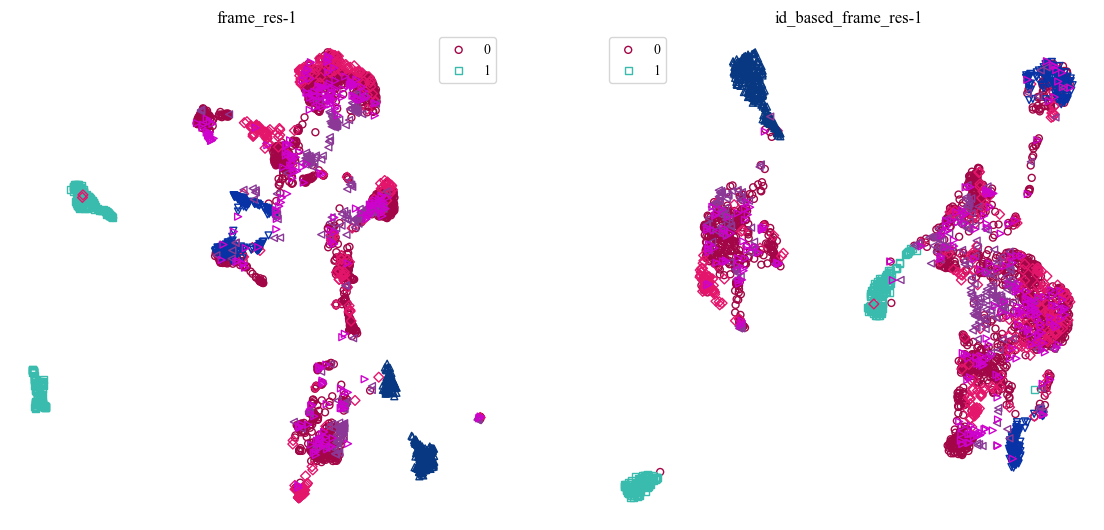

In [ ]:
_hidden_states = torch.concat([h[0] + h[1] + h[2] for h in hidden_states], dim=0)
frame_res2 = _hidden_states.mean(1)
dense_res2 = _hidden_states.mean(-1)
id_based_frame_res2 = get_id_based_frame_res(_hidden_states, full_unit_res)
key_feat = {
    # f'dense-{i}': dense_res2,
    f'frame_res-{i}' : frame_res2,
    f'id_based_frame_res-{i}' : id_based_frame_res2,
}

Silhouette Score: 0.3555572032928467 Davies-Bouldin Index: 1.1836410160252762 Calinski-Harabasz Index: 1801.566921154712
Silhouette Score: 0.3760138750076294 Davies-Bouldin Index: 1.1164835852973287 Calinski-Harabasz Index: 1958.9534354599507


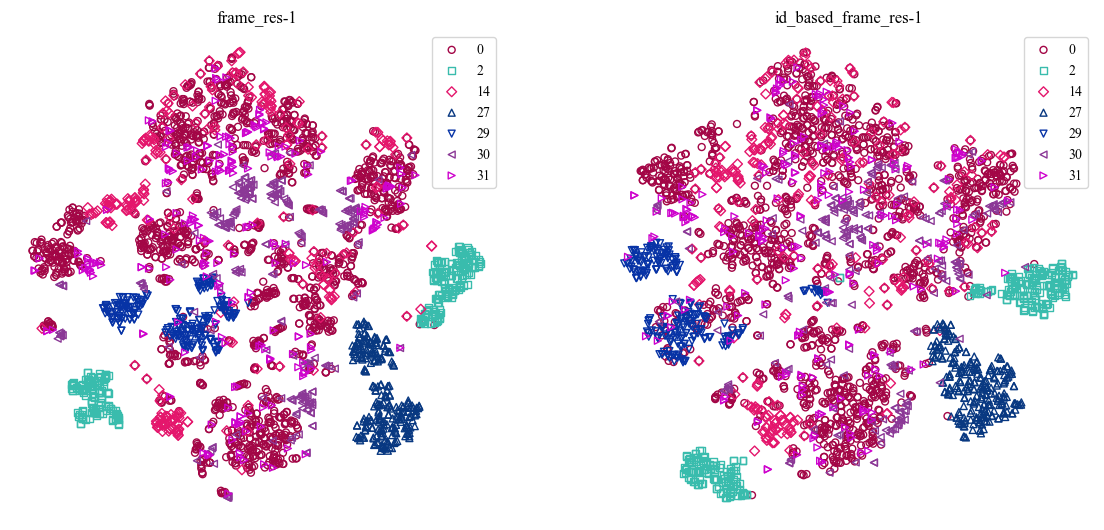

In [84]:

total = len(key_feat)
plt.figure(figsize=(14, 14))
for i, (key, value) in enumerate(key_feat.items()):
    
    ax = plt.subplot(2, 2, i+1)
    plot_cluster_res(
        value,
        # labels=labels,
        labels = list(dl_en.dataset.data["vocoder_label"]),
        cluster_method="tsne",
        legend_labels=set(list(dl_en.dataset.data["vocoder_label"])),
        print_cluster_score=True,
        ax=ax,
        # save_path=f"pngs-100/{key}.png"
    )
    ax.set_title(key)
plt.show()

In [82]:
set(list(dl_en.dataset.data["vocoder_label"]))

{0, 2, 14, 27, 29, 30, 31}